In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


In [201]:
df = pd.read_csv('data/online_retail_eda.csv', parse_dates=['InvoiceDate'])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,December
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December
...,...,...,...,...,...,...,...,...,...,...
323071,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,December
323072,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,December
323073,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,December
323074,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,December


In [202]:
df['Year'] = df['InvoiceDate'].dt.year


In [203]:
# Filter rows based on column: 'Description'
top_product = df[df['Description'].str.contains("WHITE HANGING HEART T-LIGHT HOLDER", regex=False, na=False, case=False)]

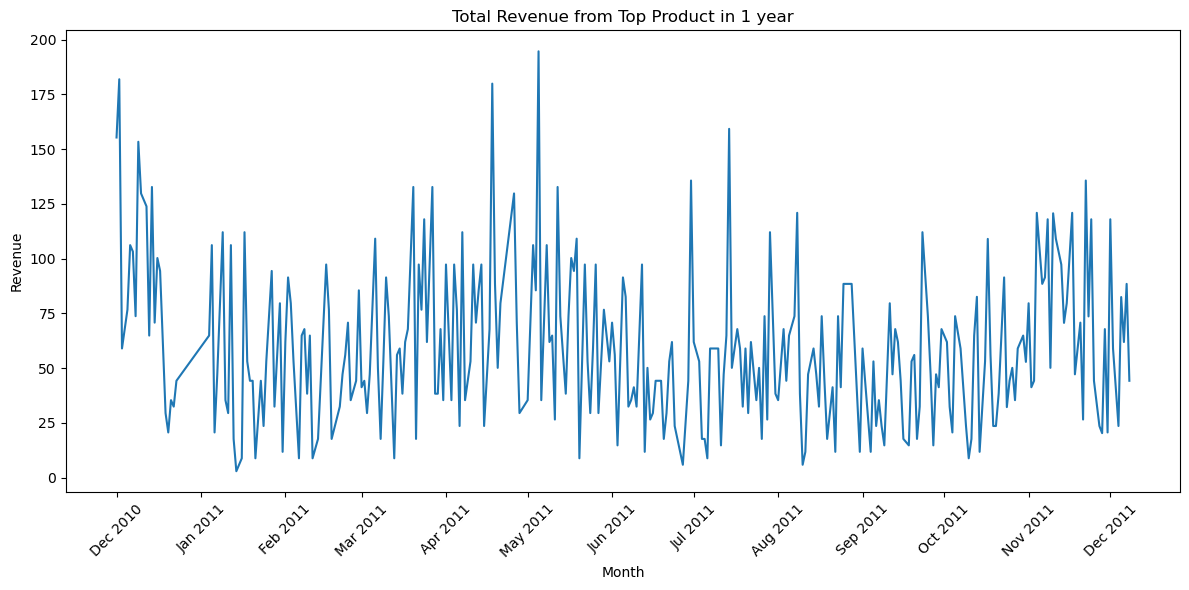

In [204]:
# Aggregate by date
sales_over_time = (
    top_product.groupby(top_product['InvoiceDate'].dt.to_period('D'))['Revenue']
      .sum()
      .reset_index()
)
sales_over_time['InvoiceDate'] = sales_over_time['InvoiceDate'].dt.to_timestamp()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_over_time, x='InvoiceDate', y='Revenue')

plt.title('Total Revenue from Top Product in 1 year')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())              # tick every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))   # format: "Jan 2011"
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [205]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [206]:
adfuller_checked = adfuller(sales_over_time['Revenue'].dropna())

print(f"ADF Statistic (Original): {adfuller_checked[0]:.4f}")
print(f"p-value (Original): {adfuller_checked[1]:.4f}")

if adfuller_checked[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

ADF Statistic (Original): -4.6938
p-value (Original): 0.0001
Interpretation: The original series is Stationary.



In [207]:
sales_over_time['Revenue_Diff'] = sales_over_time['Revenue'].diff()

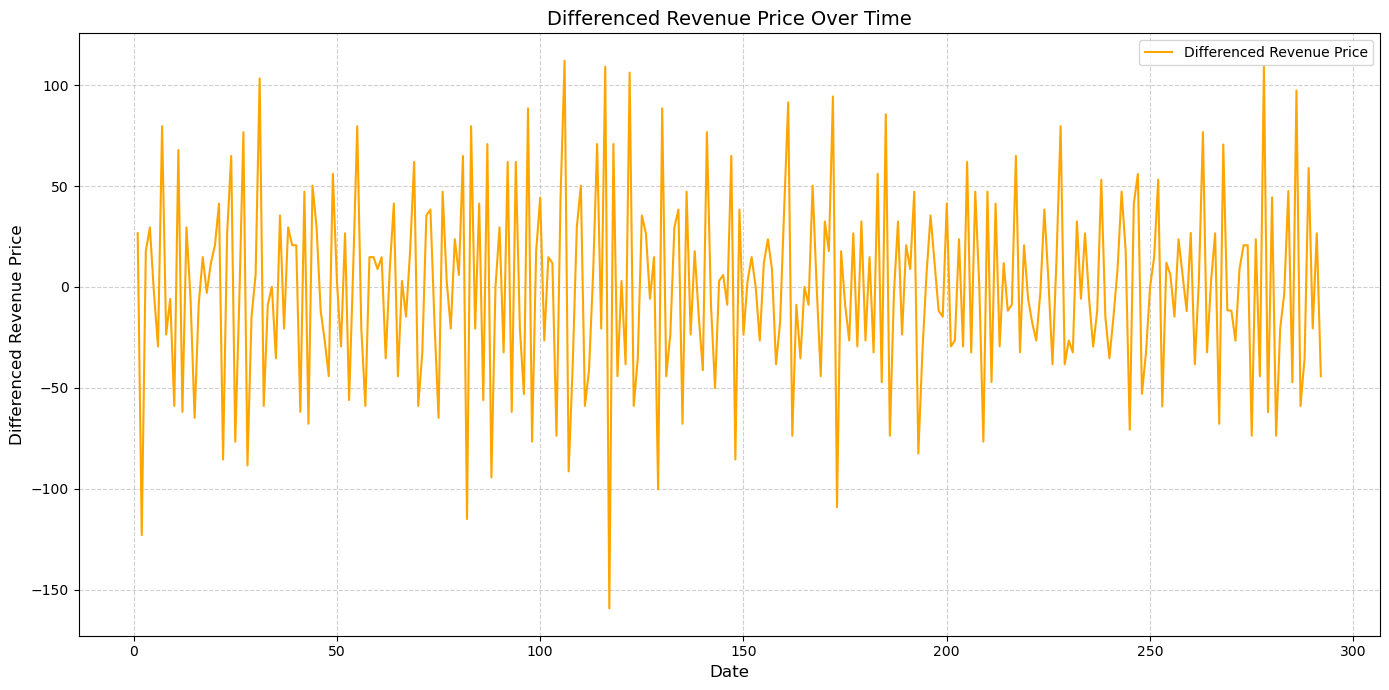

In [208]:
plt.figure(figsize=(14, 7))
plt.plot(sales_over_time.index, sales_over_time['Revenue_Diff'], label='Differenced Revenue Price', color='orange')
plt.title('Differenced Revenue Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Differenced Revenue Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

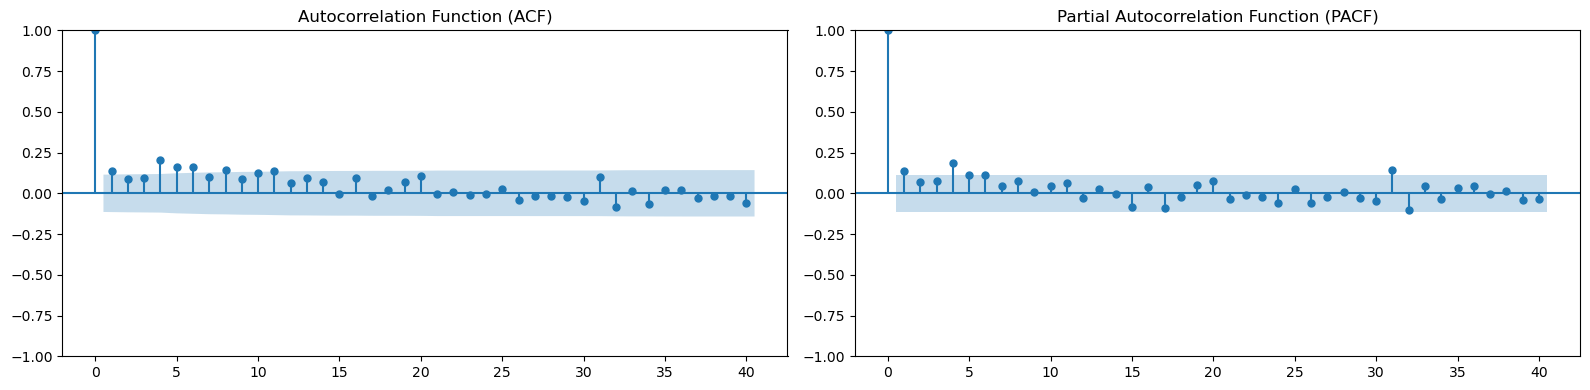

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Autocorrelation Function
plot_acf(sales_over_time['Revenue'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function
plot_pacf(sales_over_time['Revenue'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [210]:
# --- Split sales_over_time into training and testing sets
train_size = int(len(sales_over_time) * 0.75)
train, test = sales_over_time.iloc[:train_size], sales_over_time.iloc[train_size:]

# --- Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(train['Revenue'], order=(1, 0, 1))
model_fit = model.fit()


c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


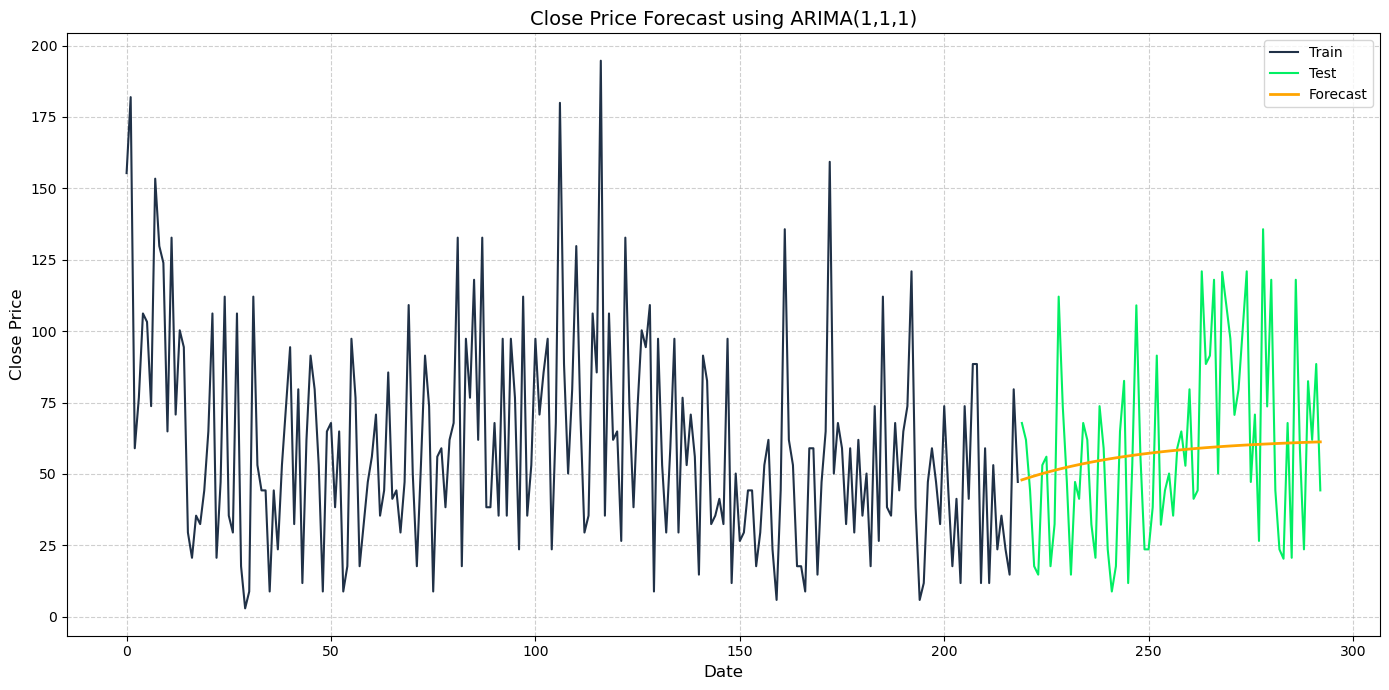

In [211]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Revenue'], label='Train', color='#203147')
plt.plot(test.index, test['Revenue'], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange', linewidth=2)

plt.title('Close Price Forecast using ARIMA(1,1,1)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [212]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 2189.0916399463476
BIC: 2202.6479268656135
